# RL Agents for Dyadic Slider

In [1]:
# Imports for each experiment
import sys, os
import importlib, time
from scipy.special import expit as sigmoid
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

import env_old
from env_old import PhysicalDyads

# lib_dir = 'lib/'

# sys.path.append(lib_dir)

In [2]:
# Here are the specifications of the Slider Enviroment
#Observation: (Mostly upper bounds)
#        Type: Box(4)
#        Num     Observation                 Min         Max
#        0 Target Position                   -1.          1. (max_ref)
#        1 Target Velocity                  -3.           3. (2pi*max_freq*max_ref)
#        2 Cursor Position                  -6.           6. (max_ref+max_error)
#        3 Cursor Velocity                  -40           40 (period*force_max/obj_mass)
#        4 Normal Force (Fn)                -20           20 
#        5 dFn/dt                          -Inf           Inf (400 from the EA study)
#
#    Actions:
#        (Box(1), Box(1))
#         -20<Box<20


In [3]:
# Here are the specifications of the Slider Enviroment
#Observation: (Mostly upper bounds)
#        Type: Box(4)
#        Num     Observation                 Min         Max
#        0  E                                -6.           6. 
#        1 dE/dt                            -Inf          Inf
#        2 Normal Force (Fn)                -20           20 
#        3 dFn/dt                          -Inf           Inf
#
#    Actions:
#        (Box(1), Box(1))
#         -20<Box<20


In [4]:
class SarsaInterface():
    nS = 10000
    df_amp = 10. #5. 
    max_f = 19.99 #20. # For saturating the integrator
    
    @classmethod
    def descretize(cls, observations):
        r, r_dot, x, x_dot, fn, fn_dot = observations
        e, e_dot = r-x, r_dot-x_dot
        d=np.zeros(4,dtype=int)
        d[0]=np.floor(sigmoid(2.2*e)*9.99)
        d[1]=np.floor(sigmoid(e_dot)*9.99)
        d[2]=np.floor(sigmoid(1*fn)*9.99)
        d[3]=np.floor(sigmoid(0.3*fn_dot)*9.99)
        return int(d[0]+10*d[1]+100*d[2]+1000*d[3])
    
    @classmethod
    def integrate(cls, action, f_old):
        if action==1:
            return min(f_old+cls.df_amp, cls.max_f)
        elif action==2:
            return max(f_old-cls.df_amp, -cls.max_f)
        else:
            return f_old
    
    
def prepSlider(seed=1234):
    env = PhysicalDyads(seed_=seed)
    discretizer = SarsaInterface.descretize
    integrator = SarsaInterface.integrate
    nS = SarsaInterface.nS
    nA = 3
    return (env, nS, nA, discretizer, integrator, 'dyad_slider') 
    
    
#    Actions:
#        Type: Discrete(2)
#        Num     Action
#        0 Do nothing
#        1 Increase force
#        1 Decrease force

## For single Agent

In [5]:
class Optimizer():
    # Optimizer class for gym environments with continuous states and discrete actions
    # Existing algorithms:
        # Sarsa (Episodic semi-gradient Sarsa control with linear function approximation)
    
    def __init__(self, env, nS, nA, discretizer, integrator, dname):
        # Arguments
        # dim is the dimensionality of the output of the extract_feature method
        # dname is the environment name
        self.env = env
        self.nS = nS
        self.nA = nA
        self.discretize = discretizer
        self.integrate = integrator
        self.dname = dname
            
  
    @staticmethod
    def eps_greedy(choices, eps):
        if np.random.rand() > eps:
            return np.argmax(choices)
        else:
            return np.random.randint(len(choices))

    @staticmethod
    def get_decay_rate(start_eps, base_eps, n_iter):
        return (base_eps/start_eps)**(1/n_iter)

    def sarsa(self, discount, alpha, eps, q_tab=None, init_f=None):
        # 1-step sarsa
        env = self.env        
        t = 0; 
        
    
        if q_tab is None:
            if init_f is None:
                init_f = lambda nS, nA: np.ones((nS, nA))
            q_tab = init_f(self.nS, self.nA)
            
        s_old = self.discretize(env.reset())
        a_old = self.eps_greedy(q_tab[s_old], eps)
        
        f1=0.;f2=0.
        
        while True:
            t += 1
            f1 = self.integrate(a_old, f1)
            observations, reward, done, _ = env.step([f1,f2]) 
            s_new = self.discretize(observations)

            a_new = Optimizer.eps_greedy(q_tab[s_new], eps)
            if done is True:
                q_tab[s_old, a_old] += alpha* (reward - q_tab[s_old, a_old])
                break

            delta = reward + discount*q_tab[s_new, a_new] - q_tab[s_old, a_old]

            q_tab[s_old, a_old] += alpha*delta 
            s_old = s_new; a_old = a_new
        return q_tab
    

In [129]:
def policy_ts(policy, plot=True):
    env, nS, nA, discretizer, integrator, _ = prepSlider(seed=np.random.randint(10000))
    
    states=[]; cum_reward = 0.
    rts, xts, fts =[],[],[]
    
    f1=0.; f2=0.
    
    observations = env.reset(renew_traj=True)
    n_steps_max = env._max_episode_steps
    
    for t in range(n_steps_max):
        rts.append(observations[0])
        xts.append(observations[2])
        fts.append(f1)
        
        action1 = policy[discretizer(observations)]
        f1 = integrator(action1, f1)
        observations, reward, done, _ = env.step([f1,f2])
        cum_reward += reward

        if done:
            break
    quality = cum_reward/t
    if plot is True:
        fig, ax = plt.subplots(2,1)
        ax[0].plot(rts, label='r')
        ax[0].plot(xts, label='x')
        ax[1].plot(fts, label='f')
        ax[0].legend(); ax[1].legend()
    return quality, rts, xts, fts


In [130]:
def greedy(q_tab):
    return np.argmax(q_tab, axis=1)

def policy_eval_sum_reward(env, policy, discretize, integrate, n_episodes=100, normalize=True):
        # Empirical Policy Evaluation
        # For solving dyadic slider by sarsa
        # Arguments:
        # n_episodes: the number of episodes used for averaging the quality of the policy
        # normalize: if True, the reward is normalized by the number of time steps.
        
        n_steps_max = env._max_episode_steps
        
        reward_vals = np.zeros(n_episodes)
        
        
        for i_episode in range(n_episodes):
            cum_reward = 0.
            observations = env.reset()
            f1=0.; f2=0.
            for t in range(n_steps_max):
                action1 = policy[discretize(observations)]
                f1 = integrate(action1, f1)
                observations, reward, done, _ = env.step([f1,f2])
                cum_reward += reward
                
                if done:
                    break
            if normalize is True:
                reward_vals[i_episode] = cum_reward /t
            else:
                reward_vals[i_episode] = cum_reward
        return np.mean(reward_vals)
    

def benchmark(algo, startepsilon, baseepsilon, decay_rate, 
              env, discretize, integrate, 
              policy_eval=policy_eval_sum_reward, 
              n_intervals=5, int_episodes=1000, n_eval=100, return_q=False):
    # Creates time series for algorithm quality across episodes
    # Arguments:
    # The algorithm hyperparameters
    # policy_eval: the function for determining the average episode reward for a policy.
    # n_intervals: the number of data points
    # int_episodes: interval of training for each consecutive data point
    # n_eval: the number of evaluations for averaging the quality of a trained policy
    
    x, y = np.zeros(n_intervals+1), np.zeros(n_intervals+1)
    
    q_tab = algo(0) 
    policy = greedy(q_tab)
    x[0] = 0
    y[0] = policy_eval(env, policy, discretize, integrate, n_episodes=n_eval)
    
    eps = startepsilon;
    # Evaluate the created policy once every int_episodes episodes
    for i in range(n_intervals):
#         if i%10==0: 
        print('interval ', i, ': quality= ', y[i])
        
        for j in range(int_episodes):
            eps = max(baseepsilon, eps*decay_rate)
            q_tab = algo(eps, q_tab=q_tab)
        policy = greedy(q_tab)
        x[i+1] = (i+1)*int_episodes
        y[i+1] = policy_eval(env, policy, discretize, integrate, n_episodes=n_eval)
    env.close()
    if return_q is True:
        return x,y, q_tab
    
    return x,y
        

In [131]:
discount=1.0
startepsilon=0.5
baseepsilon=0.01
alpha=0.01

evaluationEpisodes=5 #100
learnEpisodes=3000; n_intervals=100
t_exploit = int(0.8*learnEpisodes)
decay_rate = Optimizer.get_decay_rate(startepsilon, baseepsilon, t_exploit)

np.random.seed(5467)

In [132]:
def init1(nS, nA):
    q = -1*np.ones((nS, nA))
    for i in range(nS):
        e_digit = int('{:04d}'.format(i)[0])
#         ed_digit = int(str(i)[1])
        if e_digit <5: #if x>r
            q[i, 2] = 0
        else:
            q[i, 1] = 0
    return q

/u/sheybani/.local/lib/python3.5/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


interval  0 : quality=  -1.0674810300983804
interval  1 : quality=  -1.0756768234503893
interval  2 : quality=  -1.2279495005284562
interval  3 : quality=  -1.1201791317307592
interval  4 : quality=  -1.3011073105366608
interval  5 : quality=  -1.1874966246798795
interval  6 : quality=  -1.0609022712662384
interval  7 : quality=  -1.2106664293013552
interval  8 : quality=  -1.384859139206697
interval  9 : quality=  -0.9627077817551355
interval  10 : quality=  -0.9624514631362009
interval  11 : quality=  -1.0064589163607003
interval  12 : quality=  -1.2078371643851997
interval  13 : quality=  -1.0833557475282678
interval  14 : quality=  -0.9622210511747487
interval  15 : quality=  -0.9874075696155046
interval  16 : quality=  -0.9806607113975592
interval  17 : quality=  -1.1172514767701514
interval  18 : quality=  -1.1429945148584049
interval  19 : quality=  -0.8458348375592865
interval  20 : quality=  -0.6567687635231605
interval  21 : quality=  -0.890554330375678
interval  22 : quality

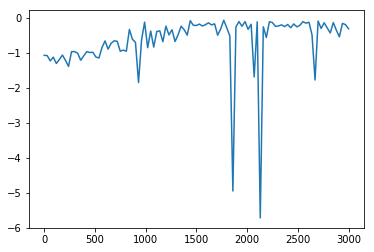

In [133]:
env, nS, nA, discretizer, integrator, dname = prepSlider()

t0 = time.time()
# initializer = lambda nS, nA: 200*np.random.rand(nS,nA)
init2 = lambda nS, nA: 200*np.ones((nS,nA))
opt = Optimizer(env,nS,nA,discretizer,integrator, dname)
algo = partial(opt.sarsa, discount, alpha, init_f=init1)
x_f1, y_f1, q_f1 = benchmark(algo, startepsilon, baseepsilon, decay_rate, 
                             env, discretizer, integrator,
                             n_intervals=n_intervals, int_episodes=int(learnEpisodes/n_intervals), 
                             n_eval=evaluationEpisodes, return_q=True)
elapsed_t = time.time() - t0
print('elapsed_t: ', elapsed_t)

plt.plot(x_f1, y_f1)

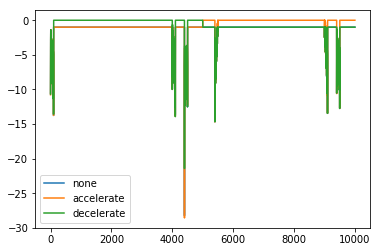

In [134]:
plt.plot(q_f1[:,0], label='none')
plt.plot(q_f1[:,1], label='accelerate')
plt.plot(q_f1[:,2], label='decelerate')
plt.legend()

/u/sheybani/.local/lib/python3.5/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


-0.23289304259622004


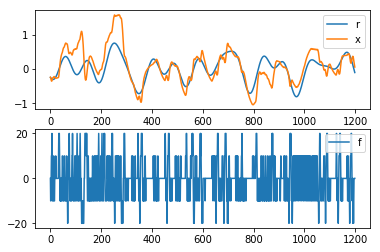

In [135]:
pol_tt = greedy(q_f1)
quality, rts, xts, fts = policy_ts(pol_tt)
print(quality)

Text(0.5, 0, 'e_dot')

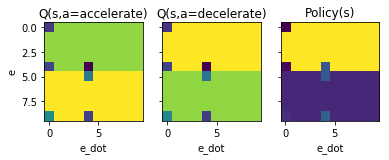

In [136]:
qa1_img = np.zeros((10,10)) #q for action 1
qa2_img = np.zeros((10,10))
pol_img = np.zeros((10,10))
for i in range(len(policy)):
    e = int('{:04d}'.format(i)[0])
    ed = int('{:04d}'.format(i)[1])
    fn = int('{:04d}'.format(i)[2])
    fnd = int('{:04d}'.format(i)[3])
    qa1_img[e,ed]+= q_f1[i,1]
    qa2_img[e,ed]+= q_f1[i,2]
    pol_img[e,ed]+= policy[i]
#     pol_img[fn,fnd]+= policy[i]
fig, ax = plt.subplots(1,3, sharey=True)
ax[0].imshow(qa1_img); ax[0].set_title('Q(s,a=accelerate)'); ax[0].set_xlabel('e_dot');ax[0].set_ylabel('e')
ax[1].imshow(qa2_img); ax[1].set_title('Q(s,a=decelerate)');ax[1].set_xlabel('e_dot')
ax[2].imshow(pol_img); ax[2].set_title('Policy(s)'); ax[2].set_xlabel('e_dot')

## For Two Agents

There's a universal simulator for interfacing the agents and the environment.

In [194]:
# Helper functions

def greedy(q_tab):
    return np.argmax(q_tab, axis=1)

def eps_greedy(choices, eps):
        if np.random.rand() > eps:
            return np.argmax(choices)
        else:
            return np.random.randint(len(choices))
        
def get_decay_rate(start_eps, base_eps, n_iter, stop_at=0.8):
    t_exploit = int(stop_at*n_iter)
    decay_rate = (base_eps/start_eps)**(1/t_exploit)
    return decay_rate

# Viz functions
def viz_q(q, policy):
    qa1_img = np.zeros((10,10)) #q for action 1
    qa2_img = np.zeros((10,10))
    pol_img = np.zeros((10,10))
    for i in range(len(policy)):
        e = int('{:04d}'.format(i)[0])
        ed = int('{:04d}'.format(i)[1])
        fn = int('{:04d}'.format(i)[2])
        fnd = int('{:04d}'.format(i)[3])
        qa1_img[fn,e]+= q[i,1]
        qa2_img[fn,e]+= q[i,2]
        pol_img[fn,e]+= policy[i]
    #     pol_img[fn,fnd]+= policy[i]
    qa1_img = qa1_img/100; qa2_img = qa2_img/100; pol_img = pol_img/100
    fig, ax = plt.subplots(1,3, sharey=True)
    ax[0].imshow(qa1_img); ax[0].set_title('Q(s,a=accelerate)'); ax[0].set_xlabel('e');ax[0].set_ylabel('fn')
    ax[1].imshow(qa2_img); ax[1].set_title('Q(s,a=decelerate)');ax[1].set_xlabel('e')
    im = ax[2].imshow(pol_img); ax[2].set_title('Policy(s)'); ax[2].set_xlabel('e')
    fig.colorbar(im)
    
def policy_ts(policy1, policy2, plot=True):
    env, _, _, discretizer, integrator, _ = prepSlider(seed=np.random.randint(10000))
    
    states=[]; cum_reward = 0.
    rts, xts, f1ts, f2ts =[],[],[],[]
    
    f1=0.; f2=0.
    
    observations = env.reset(renew_traj=True)
    n_steps_max = env._max_episode_steps
    
    for t in range(n_steps_max):
        rts.append(observations[0])
        xts.append(observations[2])
        f1ts.append(f1); f2ts.append(f2)
        
        action1 = policy1[discretizer(observations)]
        f1 = integrator(action1, f1)
        action2 = policy2[discretizer(observations)]
        f2 = integrator(action2, f2)
        
        observations, reward, done, _ = env.step([f1,f2])
        cum_reward += reward

        if done:
            break
    quality = cum_reward/t
    if plot is True:
        fig, ax = plt.subplots(2,1)
        ax[0].plot(rts, label='r')
        ax[0].plot(xts, label='x')
        ax[1].plot(f1ts, label='f1')
        ax[1].plot(f2ts, label='f2')
        ax[0].legend(); ax[1].legend()
        print('Quality = ',quality)
    return quality, rts, xts, f1ts, f2ts


In [195]:
# Agents

class TDAgent:
    # Developed for being trained on the PhysicalDyads environment, using n-step Sarsa algorithm.
    
    # Steps from observation to action:
    # 1- Calculate features: e, e', f, f' from observations={r, r', x, x', fn, f'n}
    # 2- Discretize features and Find the corresponding element in Q table
    # 3- Apply Greedy to the corresponding row in Q table to get role.
    # 4- Convert role to force. (PID, force bounds)
    # 5- Store the outcome of the action for future use
    
#     allowable_keys = ('c_err', 'c_push', 'c_pull', 'n_bins',  'tstep', 'duration','dotf_bound', 'f_bound', 'max_ref')
    
    # internal methods
    def __init__(self, agent_id, nS, nA, discretizer, integrator, 
                 q_init=None, discount=1., alpha=0.01, 
                 seed_=None, config_file=None, **kwargs):
        
        # Read the kwargs and override params from config file.
        for key in kwargs:
            setattr(self, key, kwargs[key])
                
                
        self.id = agent_id
        self.nS = nS
        self.nA = nA
        self.discretize = discretizer
        self.integrate = integrator
        
        self.discount, self.alpha = discount, alpha
        
        if q_init is None:
            self.q_tab = np.zeros((nS, nA))
        else:
            self.q_tab = q_init
            
        self.s_new, self.a_new, self.force_new = 0, 0, 0.
    
    def _role2force():
        pass
    

    
    # interface
    def get_action(self, observations, eps):
        state = self.discretize(observations)
        self.s_new = state
        self.a_new = eps_greedy(self.q_tab[self.a_new], eps)
        self.force_new = self.integrate(self.a_new, self.force_new)
        return self.force_new, self.s_new, self.a_new
    
    def _process_reward(self, reward, force):
        return self.c_err* reward + self.c_push*(-1)*abs(force/20)
    
    def update_q_act(self, observations, reward, done, eps):
        discount = self.discount; alpha = self.alpha
        
        s_old = self.s_new
        a_old = self.a_new
        force_old = self.force_new
        force_new, s_new, a_new = self.get_action(observations, eps) # Internally updates self.s_new, a_new
        
        subj_reward = self._process_reward(reward, force_old)
        
        if done is True:
            self.q_tab[s_old, a_old] += alpha* (subj_reward - self.q_tab[s_old, a_old])
        else:
            delta = subj_reward + discount*self.q_tab[s_new, a_new] - self.q_tab[s_old, a_old]
            self.q_tab[s_old, a_old] += alpha*delta 
            
        return force_new
    


class FixedAgent:

    # internal methods
    def __init__(self, agent_id, nS, nA, discretizer, integrator, 
                 q_init=None, discount=1., alpha=0.01, 
                 seed_=None, config_file=None, **kwargs):
        
        # Read the kwargs and override params from config file.
        for key in kwargs:
            setattr(self, key, kwargs[key])
                
                
        self.id = agent_id
        self.nS = nS
        self.nA = nA
        self.discretize = discretizer
        self.integrate = integrator
        
        self.discount, self.alpha = discount, alpha
        
        if q_init is None:
            self.q_tab = np.zeros((nS, nA))
        else:
            self.q_tab = q_init
            
        self.s_new, self.a_new, self.force_new = 0, 0, 0.
    
    def _role2force():
        pass
    

    
    # interface
    def get_action(self, observations, eps):
        state = self.discretize(observations)
        self.s_new = state
        self.a_new = eps_greedy(self.q_tab[self.a_new], 0)
        self.force_new = self.integrate(self.a_new, self.force_new)
        return self.force_new, self.s_new, self.a_new
    
    def _process_reward(self, reward, force):
        return self.c_err* reward + self.c_push*(-1)*abs(force/20)
    
    def update_q_act(self, observations, reward, done, eps):
        discount = self.discount; alpha = self.alpha
        
        s_old = self.s_new
        a_old = self.a_new
        force_old = self.force_new
        force_new, s_new, a_new = self.get_action(observations, eps) # Internally updates self.s_new, a_new
        
        subj_reward = self._process_reward(reward, force_old)
        
#         if done is True:
#             self.q_tab[s_old, a_old] += alpha* (subj_reward - self.q_tab[s_old, a_old])
#         else:
#             delta = subj_reward + discount*self.q_tab[s_new, a_new] - self.q_tab[s_old, a_old]
#             self.q_tab[s_old, a_old] += alpha*delta 
            
        return force_new
    


In [206]:
# For benchmarking the learning process

def dyad_eval_sum_reward(env, agent1, agent2, discretize, integrate, 
                           n_episodes=100, normalize=True):
        # Empirical Policy Evaluation
        # For solving dyadic slider by sarsa
        # Arguments:
        # n_episodes: the number of episodes used for averaging the quality of the policy
        # normalize: if True, the reward is normalized by the number of time steps.
        
        policy1 = greedy(agent1.q_tab)
        policy2 = greedy(agent2.q_tab)
        n_steps_max = env._max_episode_steps
        
        reward_vals = np.zeros(n_episodes)
        
        
        for i_episode in range(n_episodes):
            cum_reward = 0.
            observations = env.reset(renew_traj=True)
            f1=0.; f2=0.
            for t in range(n_steps_max):
                action1 = policy[discretize(observations)]
                f1 = integrate(action1, f1)
                action2 = policy2[discretizer(observations)]
                f2 = integrator(action2, f2)
                observations, reward, done, _ = env.step([f1,f2])
                cum_reward += reward
                
                if done:
                    break
            if normalize is True:
                reward_vals[i_episode] = cum_reward /t
            else:
                reward_vals[i_episode] = cum_reward
        return np.mean(reward_vals)

    
def benchmark(algo, startepsilon, baseepsilon, decay_rate, 
              env, agent1, agent2, discretize, integrate, 
              dyad_eval=dyad_eval_sum_reward, 
              n_intervals=5, int_episodes=1000, n_eval=100, return_a=False):
    # Creates time series for algorithm quality across episodes
    # Arguments:
    # The algorithm hyperparameters
    # policy_eval: the function for determining the average episode reward for a policy.
    # n_intervals: the number of data points
    # int_episodes: interval of training for each consecutive data point
    # n_eval: the number of evaluations for averaging the quality of a trained policy
    
    x, y = np.zeros(n_intervals+1), np.zeros(n_intervals+1)
    
#     agent1, agent2 = algo(0) 
#     x[0] = 0
#     y[0] = dyad_eval(env, agent1, agent2, discretize, integrate, n_episodes=n_eval)
    
    eps = startepsilon;
    # Evaluate the created policy once every int_episodes episodes
    for i in range(n_intervals):
#         if i%10==0: 
        print('interval ', i, ': quality= ', y[i])
        
        for j in range(int_episodes):
            eps = max(baseepsilon, eps*decay_rate)
            agent1, agent2 = algo(agent1, agent2, eps)
        x[i+1] = (i+1)*int_episodes
        y[i+1] = dyad_eval(env, agent1, agent2, discretize, integrate, n_episodes=n_eval)
    
    env.close()
    if return_a is True:
        return x,y, agent1, agent2
    
    return x,y

In [207]:
# Universal simulator

def simul_learning(env, agent1, agent2, eps):
    observations = env.reset(renew_traj=True)
    f1,_,_ = agent1.get_action(observations, eps) #initalize s_old, a_old
    f2,_,_ = agent2.get_action(observations, eps)
            
    while True:
        t = env.get_time()
        observations, reward, done, _ = env.step([f1, f2])
        f1 = agent1.update_q_act(observations, reward, done, eps)
        f2 = agent2.update_q_act(observations, reward, done, eps)

        if done is True:
            break
    return agent1, agent2

/u/sheybani/.local/lib/python3.5/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


interval  0 : quality=  0.0
interval  1 : quality=  -7.195830702463168
interval  2 : quality=  -8.460234092608308
interval  3 : quality=  -10.817860310941267
interval  4 : quality=  -7.883914717824323
interval  5 : quality=  -9.283420534131867
interval  6 : quality=  -11.230220132766753
interval  7 : quality=  -7.766739633245956
interval  8 : quality=  -12.164520205146836
interval  9 : quality=  -10.333091533438441
interval  10 : quality=  -9.528544733639489
interval  11 : quality=  -477.69912320443444
interval  12 : quality=  -7.978892396947421
interval  13 : quality=  -7.034185338966479
interval  14 : quality=  -265.00225223304153
interval  15 : quality=  -8.994715763475185
interval  16 : quality=  -7.241377966210711
interval  17 : quality=  -2.5974616060841056
interval  18 : quality=  -2.248144885459509
interval  19 : quality=  -3.7917799736060487
interval  20 : quality=  -3.943046079939978
interval  21 : quality=  -8.837580995419174
interval  22 : quality=  -10.433319680783878
inte

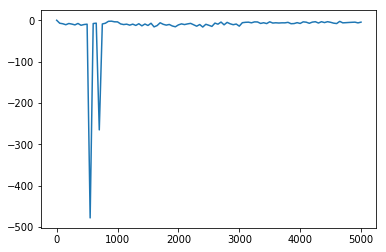

In [209]:
# Main

c_err= 1.
c_push= 1.

q1 = q_f1
q2 = -q_f1

gamma = 1. # discount factor
alpha =0.01 #learning rate
n_episodes = 5000; n_intervals=100; eval_eps=5 #100

start_eps = 1.; base_eps = 0.01
eps_decay_rate = get_decay_rate(start_eps, base_eps, n_episodes)

env, nS, nA, discretizer, integrator, dname = prepSlider()

# agent1 = TDAgent('agent1', nS, nA, discretizer, integrator, q_init=q1, 
#                  c_err=c_err, c_push=c_push, alpha =0.01) #initialize q table, 
agent1 = FixedAgent('agent1', nS, nA, discretizer, integrator, q_init=q1, 
                 c_err=c_err, c_push=c_push, alpha =0.01) #initialize q table, 
agent2 = TDAgent('agent2', nS, nA, discretizer, integrator, q_init=q2, 
                 c_err=c_err, c_push=c_push, alpha =0.01)



t0 = time.time()
algo = partial(simul_learning, env)
x_f1, y_f1, a1, a2 = benchmark(algo, start_eps, base_eps, eps_decay_rate, 
                             env, agent1, agent2, discretizer, integrator,
                             n_intervals=n_intervals, int_episodes=int(n_episodes/n_intervals), 
                             n_eval=eval_eps, return_a=True)
elapsed_t = time.time() - t0
print('elapsed_t: ', elapsed_t)

plt.plot(x_f1, y_f1)
plt.xlabel('Number of Training Episodes')
plt.ylabel('Quality')

Text(0, 0.5, 'Quality')

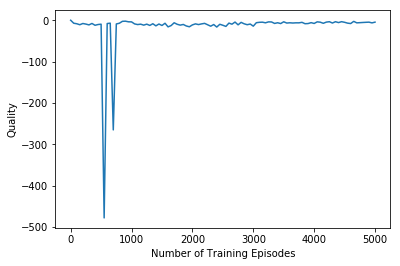

In [210]:
plt.plot(x_f1, y_f1)
plt.xlabel('Number of Training Episodes')
plt.ylabel('Quality')

### Visualize results

In [ ]:
policy1 = greedy(a1.q_tab)#greedy(agent1.q_tab)
policy2 = greedy(a2.q_tab)# greedy(agent2.q_tab)
_, rts, xts, f1ts, f2ts = policy_ts(policy1, policy2)

In [ ]:
viz_q(a1.q_tab, policy1)
viz_q(a2.q_tab, policy2)